<a href="https://colab.research.google.com/github/zsun360/zsun360.github.io/blob/main/Exam_Part_II_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exam Part II
**Self-Declaration:** All work submitted in this exam is my own work. I have paraphrased and included references to all resources that helped me arrive at my answers.

## Answer 1

The 5×5 kernel is
$$
K=\begin{vmatrix}
   1 & 4&6&4&1 \\
   4 & 16&24&16&4 \\
   6 & 24&36&24&6 \\
   4 & 16&24&16&4 \\
   1 & 4&6&4&1 \\
\end{vmatrix} \frac{1}{256}
$$
Each entry is the product of the corresponding values from the vector
$$
v= \begin{vmatrix}
   1 & 4 & 6  & 4 & 1\\
\end{vmatrix} ^T
$$

For example, row 2 is $4⋅\begin{vmatrix}
   1 & 4 & 6  & 4 & 1\\
\end{vmatrix}$, row 3 is $6⋅\begin{vmatrix}
   1 & 4 & 6  & 4 & 1\\
\end{vmatrix}$, etc.  
So
$$
K= \frac{1}{256}vv^T
 $$
Hence the kernel is separable.  
Take the 1-D kernel
$$
h=\begin{vmatrix}
   1 & 4 & 6  & 4 & 1\\
\end{vmatrix}\frac{1}{16}
$$
because $h h^T=\frac{1}{256}vv^T= K$.

So the separable version is: first convolve the image horizontally with h, then convolve the result vertically with h.

**Computation saving for a 16×16 image**

Number of pixels: $16\times16 = 256$.

- **Non-separable 2-D convolution (5×5):**  
    per pixel: 25 multiplications, 24 additions.  
    ⇒ multiplications: $256\times25 = 6400$
    ⇒ additions: $256\times24 = 6144$
    
- **Separable (two 1-D 5-tap passes):**  
    horizontal pass: 5 mult + 4 add per pixel  
    vertical pass: 5 mult + 4 add per pixel  
    per pixel total: 10 mult, 8 add.  
    ⇒ multiplications: $256\times10 = 2560$
    ⇒ additions: $256\times8 = 2048$
    

**Savings**

- Multiplications: 6400−2560=3840 fewer (25 → 10 per pixel).
    
- Additions: 6144−2048=4096 fewer (24 → 8 per pixel).

## Answer 2

We apply a Laplacian operator and a Gaussian smoothing with scale σ in three different orders.
* * *
### a. $∇^2[G(x,y)∗I(x,y)]$

First the image is smoothed with a Gaussian of scale σ, then the Laplacian (second derivative) is taken of this smoothed image.

Effect:

- High-frequency noise is strongly reduced by the Gaussian.
    
- The Laplacian then responds mainly to intensity changes that are still present after smoothing – i.e. **edges at scale σ**.
    
- Zero-crossings of the result give clean, well-localized edges that are not dominated by noise.
    

This is “Laplacian of a Gaussian” applied in two steps: smooth then differentiate.

* * *

### b. $G(x,y)∗∇^2I(x,y)$

Here we first take the Laplacian of the **raw image**, then smooth that Laplacian response with a Gaussian.

Effect:

- The Laplacian is very sensitive to noise, so noise is amplified before any smoothing.
    
- The subsequent Gaussian only averages the already-computed Laplacian response; it **blurs the edge responses** but does not prevent the noise from being enhanced in the first place.
    
- Edge locations can be less accurate and the response map is more noisy or smeared compared with (a).
    

So this is “differentiate first, then smooth”, which is generally worse for noisy images.

* * *

### c. $∇^2G(x,y)∗I(x,y)$

Here we pre-compute the Laplacian of the Gaussian itself to form a single composite kernel (the LoG kernel), then convolve that kernel with the image.

Effect:

- This is equivalent in spirit to (a): the filter itself combines smoothing and second-derivative behavior, so when it is convolved with the image, we obtain **edges at scale σ with built-in smoothing**.
    
- In continuous theory, (a) and (c) give the same result; in discrete implementation they may differ slightly due to sampling, but conceptually they are the same “Laplacian-of-Gaussian edge detector”.
    

* * *

**Summary**

- both (a) and (c) implement **LoG filtering**: smoothing and second derivative combined, giving scale-controlled, noise-robust edge detection.
    
- (b) differentiates before smoothing, so it amplifies noise and then blurs the response, giving less clean and less well-localized edges.

## Answer 3

### (a) Output image(s) and method choice

I apply **multi-scale Laplacian of Gaussian (LoG) blob detection** to the given fruit image.
The output image shows the detected fruits as green circles overlaid on the original RGB image; each circle is centred at a LoG local maximum and its radius corresponds to the detected blob scale. The program also prints the **approximate fruit count** as the number of detected blobs (in my final configuration this is on the order of ~20, slightly higher than the visually observed ~15 fruits, because some strong highlights are still detected as small blobs).

I chose **LoG/DoG blob detection instead of circular Hough Transform** for the following reasons:

Many objects are **not perfect circles** and are **partially blocked** (e.g., apples touching each other, kiwis partly hidden). Hough Transform assumes clear circular edges and works best for isolated, complete circles.

Blob detection operates in **scale-space** and is naturally suited for detecting **compact, approximately round regions** at multiple sizes. This fits our scene, where fruit sizes range from small persimmons/kiwis to a large melon.

The background is almost black and the fruits are bright, so each fruit forms a **distinct intensity “blob”**; LoG is designed exactly to find such local extrema in space and scale.

Because of specular highlights on shiny fruits (especially apples), a few bright spots are still picked up as small blobs, so the estimate is slightly higher than the true number of fruits. This behaviour, and the trade-off between recall and over-detection, is expected for LoG on real glossy objects.
***
### (b) Pre-processing steps and their purpose

Before running blob detection, I apply the following pre-processing steps:

1. Grayscale conversion

- Convert the RGB image to a single-channel grayscale image.

- Reason: LoG/DoG operates on intensity; colour is not required for counting fruits and removing colour simplifies the processing.

2. Strong Gaussian smoothing
``` python
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (25, 25), sigmaX=8.9)
```

- Reason: The fruits (especially the melon and coconut) have **fine texture** and **strong specular highlights**. These generate many small high-frequency extrema that LoG would otherwise interpret as separate blobs.

- A relatively large Gaussian kernel (25×25, σ≈8.9) smooths out these high-frequency patterns and highlights, while preserving the **overall shape and location of each fruit**. This reduces the number of spurious small blobs.

3. Implicit background suppression via intensity and size

- The dark background has very low intensity after smoothing and therefore yields negligible LoG response.

- Additionally, in the post-processing step I discard blobs whose radius is below a minimum “fruit scale”, so **tiny background responses and residual highlights are filtered out**.

These steps ensure that the blob detector responds mainly to **large, smooth fruit regions** and not to fine texture or noise.
***
### (c) Use of built-in functions and parameter choices

I use **OpenCV for image I/O and pre-processing and scikit-image for multi-scale LoG blob detection**.

### Core detection code (simplified):
```python
from skimage.feature import blob_log
from math import sqrt, hypot

# 1. Pre-processing
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (25, 25), sigmaX=8.9)

# 2. Multi-scale LoG blob detection
min_radius = 29      # smallest expected fruit radius (px)
max_radius = 130     # largest expected fruit radius (melon)

min_sigma = min_radius / sqrt(2.0)
max_sigma = max_radius / sqrt(2.0)

blobs = blob_log(
    gray_blur / 255.0,
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=10,     # number of scales sampled between min_sigma and max_sigma
    threshold=0.049,  # minimum LoG response to keep a blob
    overlap=0.3       # non-maximum suppression within the detector itself
)
# convert sigma to radius
# r ≈ sqrt(2) * sigma
```

### Rationale for parameter choices:

- min_radius, max_radius
Estimated from the image by measuring approximate radii of the smallest and largest fruits in pixels. They restrict the LoG search to scales that correspond to **whole fruits**, not tiny texture elements.

- num_sigma = 10
Provides a reasonable sampling of the scale range; more scales increase computation time with limited benefit.

- threshold = 0.049
Controls how strong the LoG response must be to be accepted. I tuned this empirically:

Too low → many blobs on highlights and texture.

Too high → some smaller fruits are missed.
The chosen value keeps strong fruit-level blobs while discarding weaker high-frequency responses.

- overlap = 0.3 (in blob_log)
Performs a first non-maximum suppression so that multiple very similar blobs at the same scale are merged.

After `blob_log`, I apply an additional **spatial merging and size filtering** step:

Blobs are sorted by radius (largest first).

Two blobs are merged (treated as the same fruit) only if:

Their centres are close compared to their combined radii (strong spatial overlap), and

Their radii are similar (difference less than about 50% of the larger radius).

Finally, blobs with radius smaller than the minimum “fruit radius” are discarded.

This post-processing ensures that:

Each physical fruit is typically represented by **one dominant blob**.

Very small blobs caused by residual highlights or texture are removed.

The final program therefore returns **an approximate count of fruits** in the image: all true fruits are detected, but a few bright specular spots are still counted as additional small blobs, which is a known limitation of blob-based detection on glossy surfaces.

### (c) Python code with parameter choices and comments

Below is a complete example using **OpenCV** for I/O + pre-processing and **scikit-image** for LoG blob detection.

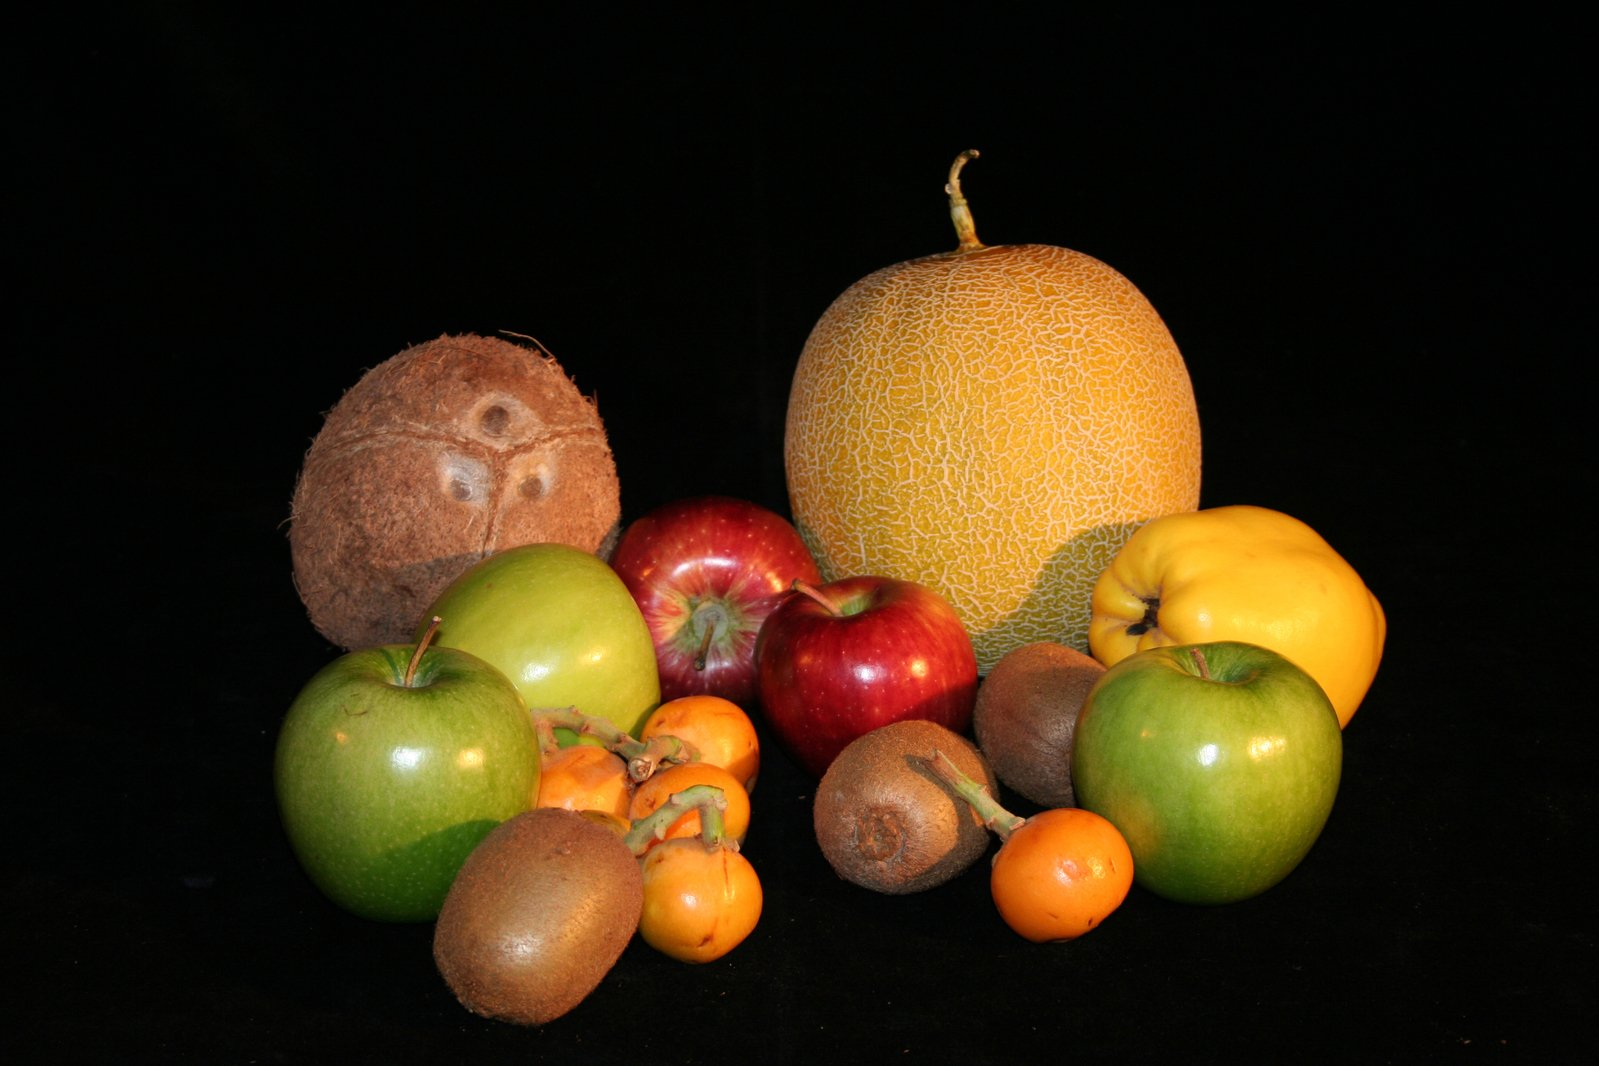

Approximate number of fruits: 23


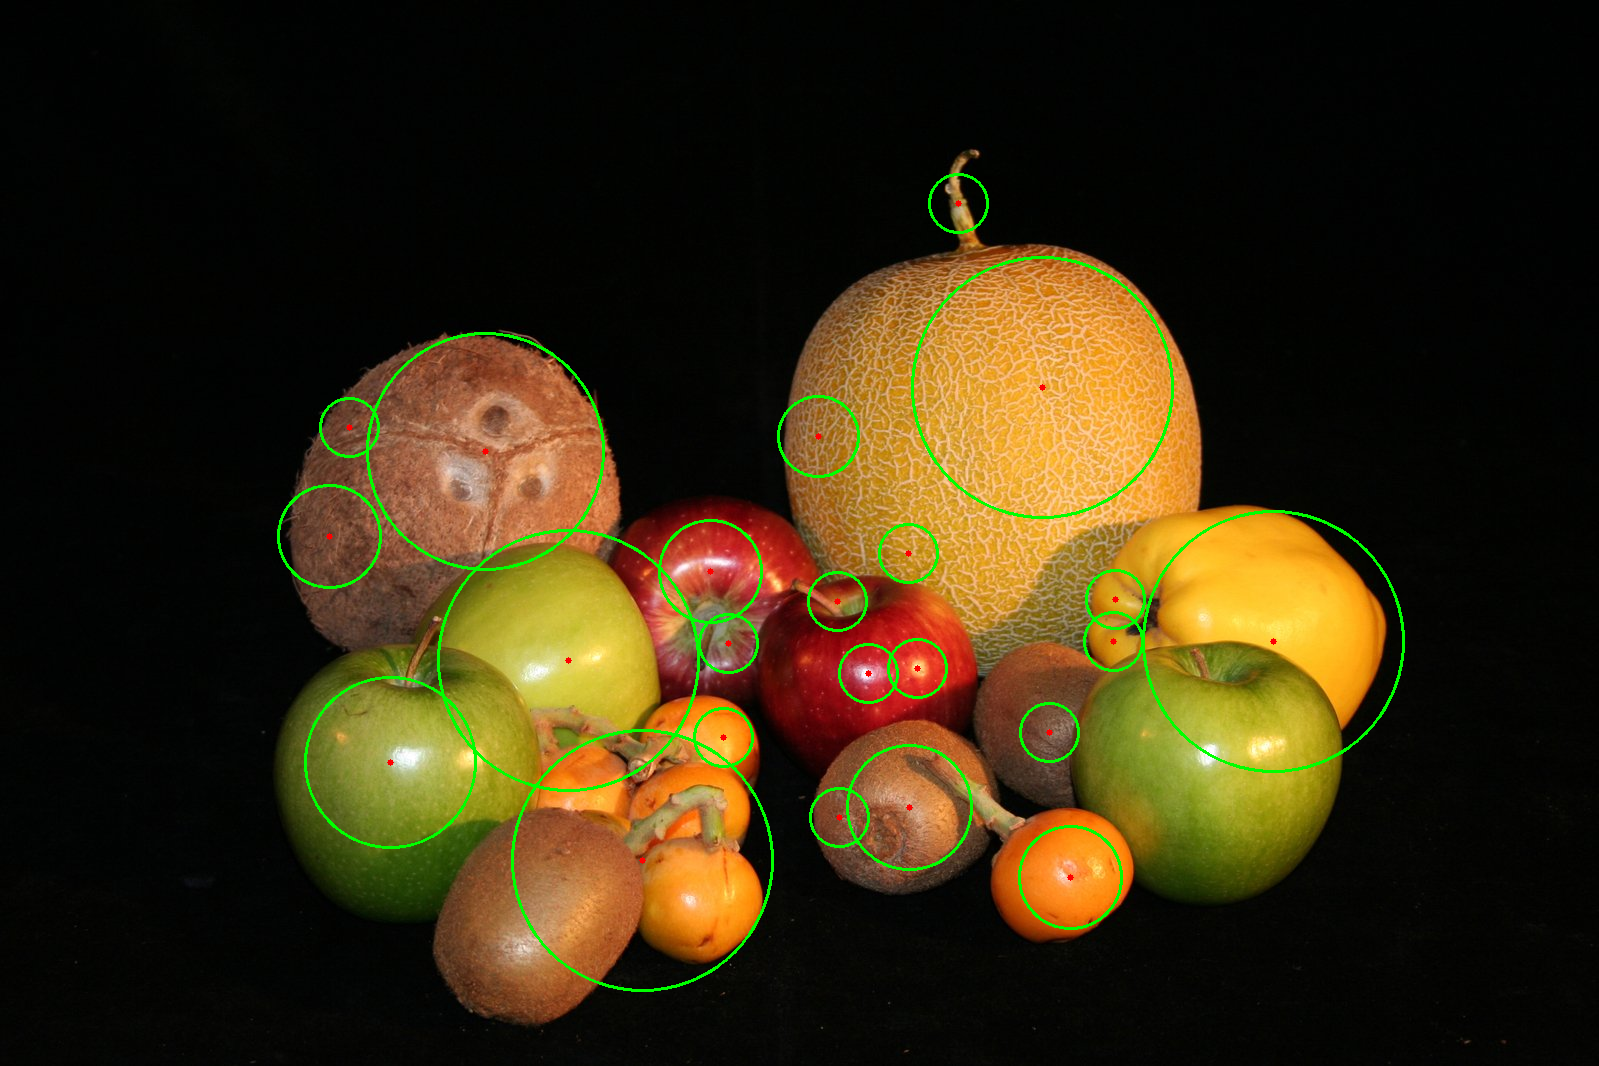

In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.feature import blob_log
from math import sqrt, hypot

# ---------- 1. Load and pre-process image ----------
img = cv2.imread("sample_data/ExamImageQ3.jpg")     # path to the given fruit image
orig = img.copy()
cv2_imshow(orig)
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# local histogram equalization (improves contrast on each fruit)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_eq = clahe.apply(gray)

# strong Gaussian smoothing to remove small noise
gray_blur = cv2.GaussianBlur(gray, (25, 25), sigmaX=8.9)

# simple threshold to separate dark background from fruits
# 20 was chosen empirically by looking at the histogram:
# background pixels are clustered near 0, fruits are > 20
_, mask = cv2.threshold(gray_blur, 20, 255, cv2.THRESH_BINARY)

# close small gaps inside fruits (optional but helps for kiwis)
kernel = np.ones((7, 7), np.uint8)
mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# ---------- 2. Multi-scale LoG blob detection ----------
# The image resolution is ~1600x1000 pixels.
# Small persimmons/kiwis have radius ≈ 20–30 px,
# apples ≈ 40–60 px, big melon ≈ 120 px.
# For LoG, sigma is related to radius by r ≈ sqrt(2) * sigma.

min_radius = 29
max_radius = 130

min_sigma = min_radius / sqrt(2.0)
max_sigma = max_radius / sqrt(2.0)

# The threshold controls how strong a LoG response must be to be kept.
# It is proportional to the maximum of the Laplacian response; here
# 0.03 was found to keep real fruits and discard noise.
blobs = blob_log(
    gray_blur / 255.0,
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=10,
    threshold=0.049,
    overlap=0.3,   # maximum allowed overlap between two blobs (for NMS)
)

def merge_blobs(blobs, overlap_factor=0.6, radius_ratio=0.5):
    """
    blobs: (y, x, sigma)
    overlap_factor: 控制两个圈中心距离需要多近才认为重叠
    radius_ratio:   控制半径需要多相似才认为是同一个水果
    """
    # 按半径从大到小排序，优先保留大的圈
    blobs_sorted = sorted(blobs, key=lambda b: b[2], reverse=True)
    kept = []

    for y, x, s in blobs_sorted:
        r = s * sqrt(2.0)
        keep = True
        for yk, xk, sk in kept:
            rk = sk * sqrt(2.0)

            d = hypot(x - xk, y - yk)

            # 条件1：中心足够近（两个圈有较大重叠）
            cond_overlap = d < overlap_factor * (r + rk)

            # 条件2：半径相近（说明可能是同一个水果上的重复响应）
            cond_similar_radius = abs(r - rk) < radius_ratio * max(r, rk)

            if cond_overlap and cond_similar_radius:
                keep = False   # 当作同一水果的重复检测，丢掉
                break

        if keep:
            kept.append((y, x, s))

    return kept

merged = merge_blobs(blobs)



# Each blob is (y, x, sigma). Convert sigma → radius.
blobs[:, 2] = blobs[:, 2] * sqrt(2)

# ---------- 3. Filter blobs using foreground mask ----------

min_fruit_radius = 20  # 像素
final_blobs = []
for (y, x, s) in merged:
    r = s * sqrt(2.0)
    if r >= min_fruit_radius:
        final_blobs.append((int(x), int(y), int(r)))

# ---------- 4. Draw results ----------
result = img.copy()
for (x, y, r) in final_blobs:
    cv2.circle(result, (x, y), r, (0, 255, 0), 2)
    cv2.circle(result, (x, y), 3, (0, 0, 255), -1)

print("Approximate number of fruits:", len(final_blobs))
cv2.imwrite("fruits_detected_refined.png", result)

cv2_imshow(result)